#ARFI Histology Lesion Analysis
This notebook presents a comparison of ARFI lesion reads compared to whole mount histology reads, comparing index lesions, clinically-significant lesion and benign confounders, including atrophy and BPH.

This notebook replaces the ```arfi_histology_analysis.py``` script and the corresponding ```arfi_histology_analysis.md``` output that were becoming really cumbersome with the different subanalyses.

In [97]:
%pylab inline
%load_ext autoreload
%autoreload 2

from lesion_analysis import LesionAnalysis
invivo_path = '/luscinia/ProstateStudy/invivo'

from IPython.display import display, Image
import matplotlib.pyplot as plt

class countTotalPercent:
    """
    calculate percentage (p) from 2 input ints, count (c) and total (t)
    used for printed output below
    """
    def __init__(self, c, t):
        self.c = c
        self.t = t
        self.p = 100*float(c)/float(t)
        
# open LaTeX source file with variables to read into Results section directly so that they don't have to get manually updated
# for each subsequent re-anlaysis iteration
analysis_results = open('analysis_results.tex', 'w')
analysis_results.write('% DO NOT MANUALLY EDIT THIS FILE!\n')
analysis_results.write('% GENERATED BY arfi_histology_lesion_analysis.ipynb\n')

def write_analysis_result(varname, value, analysis_results=analysis_results):
    """
    write a new LaTeX command with specified variable name and value
    """
    if type(value) is float:
        value = str(round(value, 1))
    analysis_results.write('\\newcommand{\%s}{%s}\n' % (varname, value))

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


`%matplotlib` prevents importing * from pylab and numpy


##Valid Study Subjects

In [98]:
ValidPatientNums = []
for n, p in enumerate(range(56, 107)):
    P = LesionAnalysis(p, invivo_path)
    if P.valid:
        ValidPatientNums.append(p)
    
print "%i of %i study subjects valid" % (len(ValidPatientNums), n+1)
print "Valid study subjects: %s" %  ValidPatientNums

29 of 51 study subjects valid
Valid study subjects: [56, 58, 59, 60, 62, 63, 64, 70, 71, 72, 73, 76, 78, 79, 82, 83, 84, 86, 87, 89, 91, 92, 93, 94, 95, 96, 99, 102, 104]


##Index Lesions
Index lesions were considered matched if they existed in the nearest-neighbor set of the histology-identified region.  An exact region match is not presented since there is so much uncertainty with the exact region for both the ARFI image and the histology.  There was at least one case that did not have an index lesion because the only PCA did not meet the threshold for clinical significance.

ARFI nearest-neighbor index PCA sensitivity: 22/28 (79%)
ARFI-detected index PCA study subjects: [(58, 'posterior'), (59, 'posterior'), (60, 'posterior'), (62, 'posterior'), (71, 'posterior'), (72, 'posterior'), (73, 'posterior'), (76, 'posterior'), (78, 'anterior'), (79, 'posterior'), (82, 'posterior'), (83, 'posterior'), (84, 'posterior'), (86, 'posterior'), (87, 'posterior'), (89, 'posterior'), (91, 'posterior'), (93, 'posterior'), (94, 'posterior'), (96, 'posterior'), (99, 'posterior'), (104, 'posterior')]
ARFI-missed study subjects: [(56, 'anterior'), (63, 'posterior'), (64, 'posterior'), (92, 'posterior'), (95, 'posterior'), (102, 'posterior')]
ARFI POSTERIOR index PCA lesion sensitivity: 21/26 (81%)
ARFI ANTERIOR index PCA lesion sensitivity: 1/2 (50%)


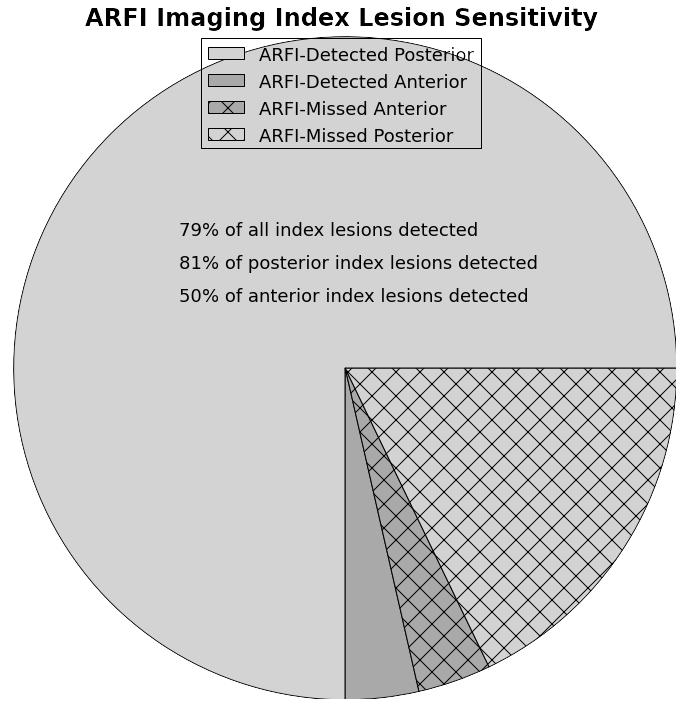

In [99]:
IndexMatch = []
IndexMiss = []
for p in ValidPatientNums:
    P = LesionAnalysis(p, invivo_path)
    if 'index' in P.histology:
        if P.histology['index'] is not None:
            if P.index_match['nn']:
                IndexMatch.append((p, P.histology['index']['location']))
            else:
                IndexMiss.append((p, P.histology['index']['location']))
        
ARFI_Index = countTotalPercent(len(IndexMatch), len(IndexMatch)+len(IndexMiss))

print "ARFI nearest-neighbor index PCA sensitivity: %i/%i (%.f%%)" % (ARFI_Index.c, ARFI_Index.t, ARFI_Index.p)
write_analysis_result('arfiIndexSensitivity', ARFI_Index.p)
print "ARFI-detected index PCA study subjects: %s" % IndexMatch
print "ARFI-missed study subjects: %s" % IndexMiss

# posterior index lesion sub-analysis
TotalIndexPosteriorMatch = len([i for i, j in enumerate(IndexMatch) if j[1] == 'posterior'])
TotalIndexPosteriorMiss = len([i for i, j in enumerate(IndexMiss) if j[1] == 'posterior'])
TotalIndexPosterior = TotalIndexPosteriorMatch + TotalIndexPosteriorMiss
ARFI_posterior = countTotalPercent(TotalIndexPosteriorMatch, TotalIndexPosterior)
print "ARFI POSTERIOR index PCA lesion sensitivity: %i/%i (%.f%%)" % (ARFI_posterior.c, ARFI_posterior.t, ARFI_posterior.p)
write_analysis_result('arfiPosteriorIndexSensitivity', ARFI_posterior.p)

# anterior index lesion sub-analysis
TotalIndexAnteriorMatch = len([i for i, j in enumerate(IndexMatch) if j[1] == 'anterior'])
TotalIndexAnteriorMiss = len([i for i, j in enumerate(IndexMiss) if j[1] == 'anterior'])
TotalIndexAnterior = TotalIndexAnteriorMatch + TotalIndexAnteriorMiss
ARFI_anterior = countTotalPercent(TotalIndexAnteriorMatch, TotalIndexAnterior)
print "ARFI ANTERIOR index PCA lesion sensitivity: %i/%i (%.f%%)" % (ARFI_anterior.c, ARFI_anterior.t, ARFI_anterior.p)
write_analysis_result('arfiAnteriorIndexSensitivity', ARFI_anterior.p)

# generate some pie charts
labels = ['ARFI-Detected Posterior', 'ARFI-Detected Anterior', 'ARFI-Missed Anterior', 'ARFI-Missed Posterior']
colors = ['lightgray', 'darkgray', 'darkgray', 'lightgray']

plt.figure(figsize=(12,12))
slices = [ARFI_posterior.c, ARFI_anterior.c, ARFI_anterior.t-ARFI_anterior.c, ARFI_posterior.t-ARFI_posterior.c]
patches, texts = plt.pie(slices, colors=colors)
plt.axis('equal')
plt.title('ARFI Imaging Index Lesion Sensitivity', fontsize=24, fontweight='bold')
for i in range(0,len(texts)):
    texts[i].set_fontsize(18)
patches[2].set_hatch('x')
patches[3].set_hatch('x')
plt.legend(patches, labels, fontsize=18, loc='upper center')
plt.text(-0.5, 0.4, '79% of all index lesions detected', fontsize=18, color='black')
plt.text(-0.5, 0.3, '81% of posterior index lesions detected', fontsize=18, color='black')
plt.text(-0.5, 0.2, '50% of anterior index lesions detected', fontsize=18, color='black')
savefig('ARFI_IndexLesionSensitivity.eps', dpi=1200)

###Missed Case Histology

/luscinia/ProstateStudy/invivo/Patient56/Histology/Images/montage.png


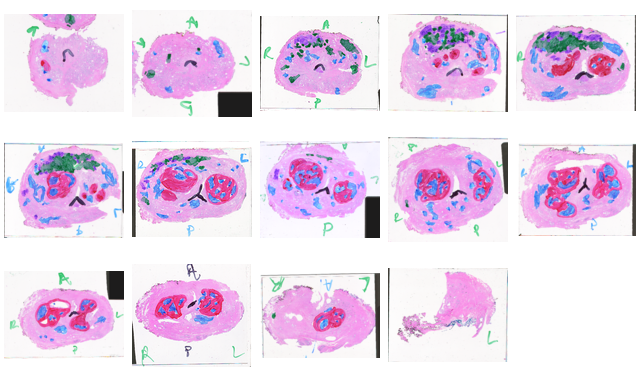

/luscinia/ProstateStudy/invivo/Patient63/Histology/Images/montage.png


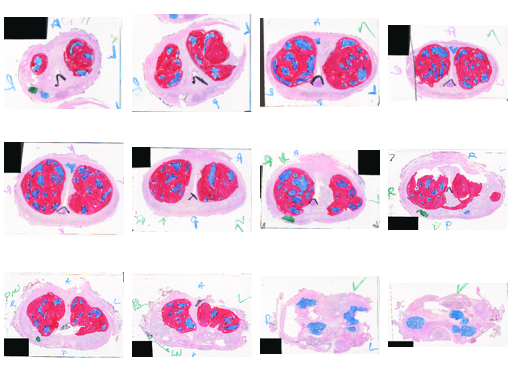

/luscinia/ProstateStudy/invivo/Patient64/Histology/Images/montage.png


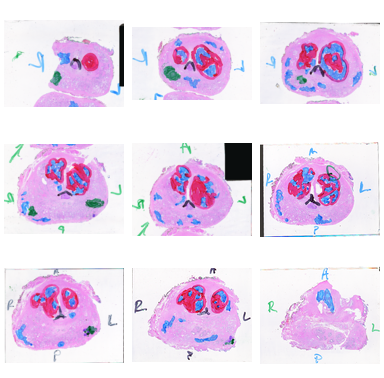

/luscinia/ProstateStudy/invivo/Patient92/Histology/Images/montage.png


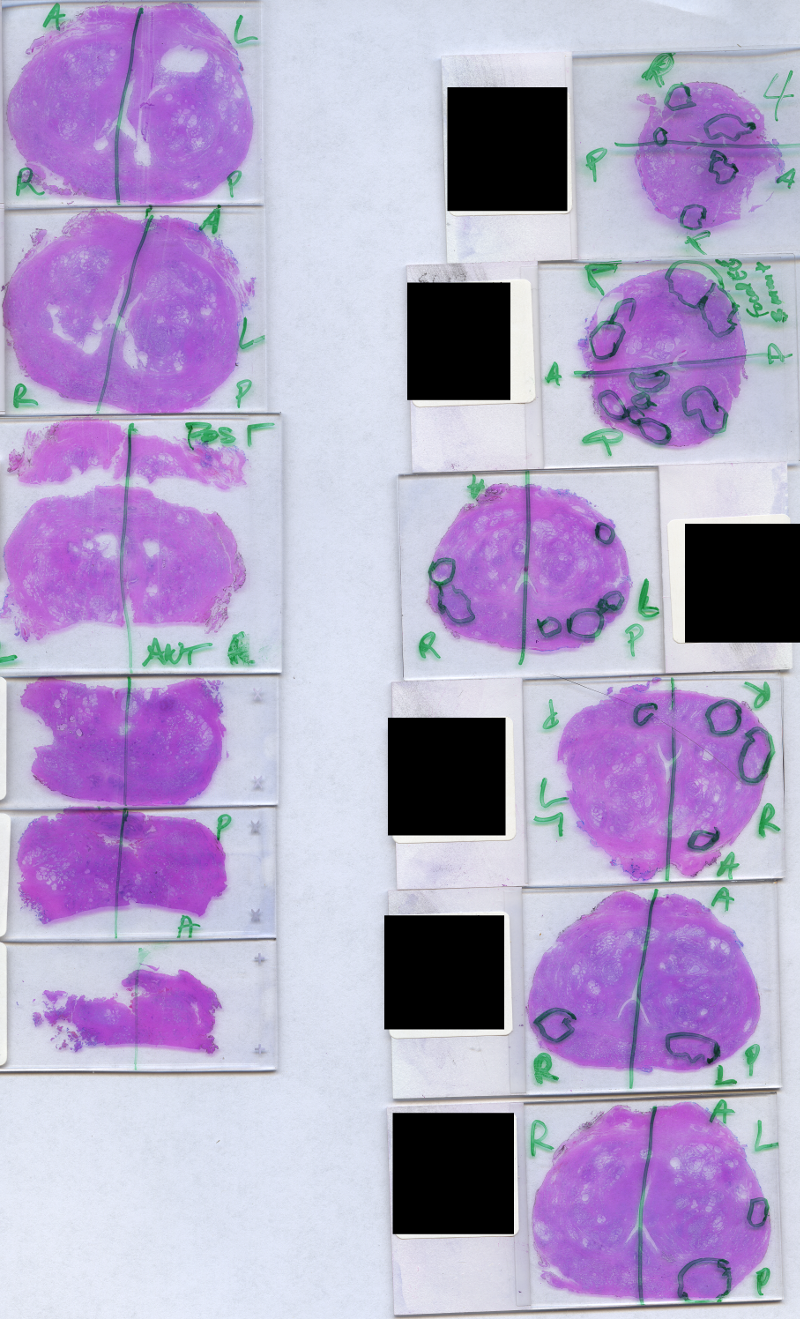

/luscinia/ProstateStudy/invivo/Patient95/Histology/Images/montage.png


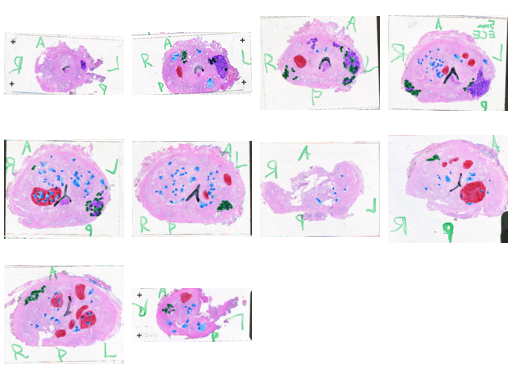

/luscinia/ProstateStudy/invivo/Patient102/Histology/Images/montage.png


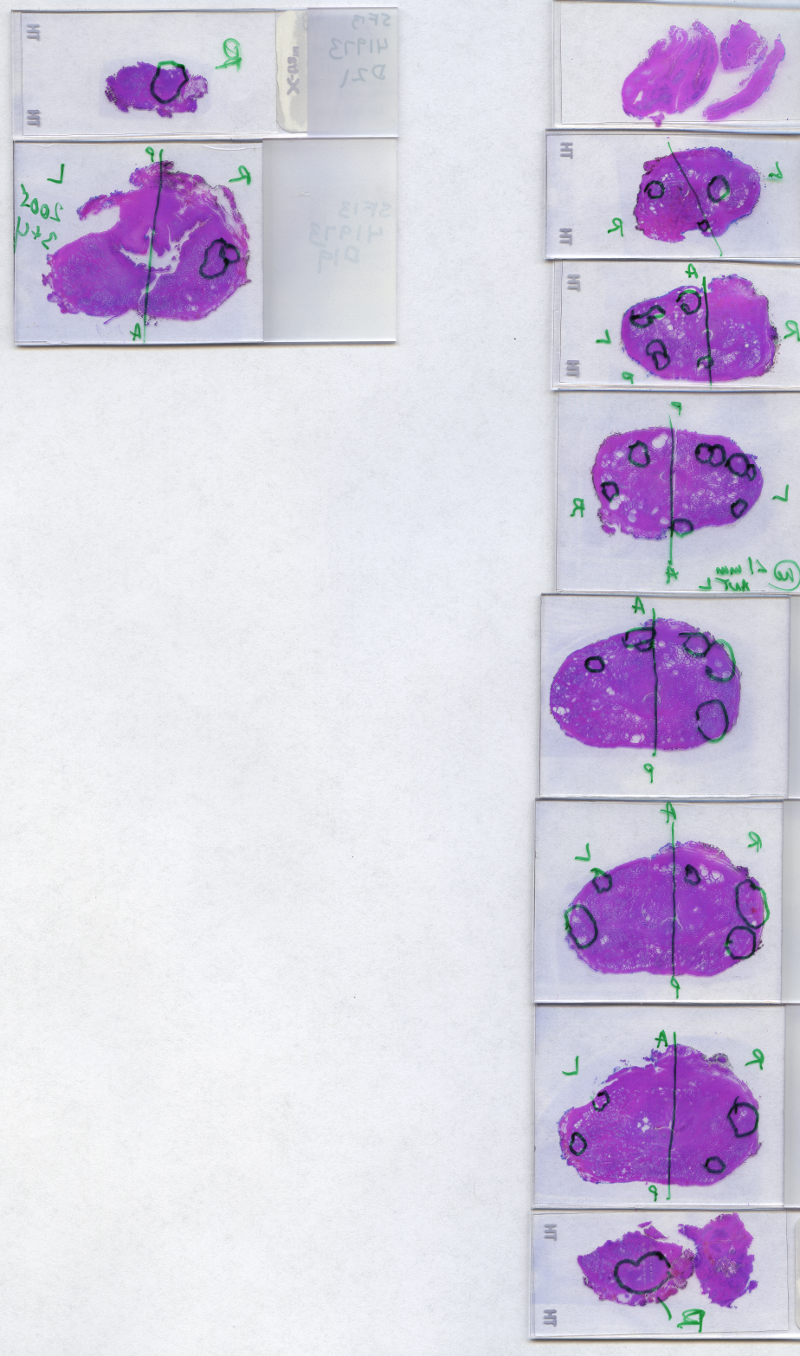

In [100]:
for p in [i for i,j in IndexMiss]:
    montage = '%s/Patient%s/Histology/Images/montage.png' % (invivo_path, p)
    print montage
    display(Image(filename=montage))

##ARFI Lesion Characterization

###True Positives (Clinically-Significant PCA)

In [101]:
# THIS IS STILL BROKEN!!

ClinSigMatch = []
ClinSigMatchCases = []
ClinSigMissCases = []
ClinSigMiss = []

for p in ValidPatientNums:
    P = LesionAnalysis(p, invivo_path)
    if P.clin_sig_match is not None:
        for yay, locat in P.clin_sig_match:
            if yay is True:
                ClinSigMatch.append(locat)    
                ClinSigMatchCases.append(p)
            elif yay is False:
                ClinSigMissCases.append(p)
                ClinSigMiss.append(locat)
                
ClinSigMatchCases = set(ClinSigMatchCases)
ClinSigMissCases = set(ClinSigMissCases)

ARFItotal = len(ClinSigMatch) + len(ClinSigMiss)
ARFIclinsig = countTotalPercent(len(ClinSigMatch), ARFItotal)

ARFIposterior = countTotalPercent(len([i for i in ClinSigMatch if i == 'posterior']), len(ClinSigMatch))     
ARFIanterior = countTotalPercent(len([i for i in ClinSigMatch if i == 'anterior']), len(ClinSigMatch))
ARFImissposterior = countTotalPercent(len([i for i in ClinSigMiss if i == 'posterior']), len(ClinSigMiss))     
ARFImissanterior = countTotalPercent(len([i for i in ClinSigMiss if i == 'anterior']), len(ClinSigMiss))

# print and write interesting results to include in the manuscript
print "%i/%i (%.f%%) of read lesions were clinically significant, with a mode IOS score of XXXX" % \
    (ARFIclinsig.c, ARFIclinsig.t, ARFIclinsig.p)
    
write_analysis_result('arfiClinSig', ARFIclinsig.p)
print "\tStudy subjects: %s" % ClinSigMatchCases
    
print "\t%i/%i (%.f%%) of read clinically-significant lesions were posterior, with a mode IOS score of XXXX" % \
    (ARFIposterior.c, ARFIposterior.t, ARFIposterior.p)
write_analysis_result('arfiClinSigPosterior', ARFIposterior.p)    
    
print "\t%i/%i (%.f%%) of read clinically-significant lesions were anterior, with a mode IOS score of XXXX" % \
    (ARFIanterior.c, ARFIanterior.t, ARFIanterior.p) 
write_analysis_result('arfiClinSigAnterior', ARFIanterior.p)

print "\t%i/%i (%.f%%) of read clinically-insignificant lesions were posterior, with a mode IOS score of XXXX" % \
    (ARFImissposterior.c, ARFImissposterior.t, ARFImissposterior.p)
write_analysis_result('arfiClinInsigPosterior', ARFImissposterior.p)    
    
print "\t%i/%i (%.f%%) of read clinically-insignificant lesions were anterior, with a mode IOS score of XXXX" % \
    (ARFImissanterior.c, ARFImissanterior.t, ARFImissanterior.p) 
write_analysis_result('arfiClinInsigAnterior', ARFImissanterior.p)

21/27 (78%) of read lesions were clinically significant, with a mode IOS score of XXXX
	Study subjects: set([96, 91, 71, 72, 73, 76, 79, 99, 83, 84, 94, 86, 87, 89, 58, 59, 60, 93, 62])
	21/21 (100%) of read clinically-significant lesions were posterior, with a mode IOS score of XXXX
	0/21 (0%) of read clinically-significant lesions were anterior, with a mode IOS score of XXXX
	6/6 (100%) of read clinically-insignificant lesions were posterior, with a mode IOS score of XXXX
	0/6 (0%) of read clinically-insignificant lesions were anterior, with a mode IOS score of XXXX


###False Positives
If the ARFI imaging regions of suspicion (ROS) did not contain clinically-significant, then what did they contain?

In [102]:
ARFIatrophy = []
ARFIbph = []
ARFI_FalsePositive = []
NoHistLesion = []

for p in ValidPatientNums:
    P = LesionAnalysis(p, invivo_path)
    if P.false_positive:
        ARFI_FalsePositive.append([P.pnum, P.false_positive])
        
ARFI_ClinInsigPCA = [z for x, y in ARFI_FalsePositive for z in y if 'pca' in z]

if not ARFI_ClinInsigPCA:
    ARFI_ClinInsigPCA = None

print "Number of non-clinically significant PCA: %s" % len(ARFI_ClinInsigPCA)
        
for i, j in ARFI_FalsePositive:
    if 'atrophy' in j:
        ARFIatrophy.append(i)
    elif 'bph' in j:
        ARFIbph.append(i)
        
if not ARFIatrophy:
    ARFIatrophy = None
    
print "Number of study subjects with ATROPHY in ROS: %s" % len(ARFIatrophy)

if not ARFIbph:
    ARFIbph = None

print "Number of study subjects with BPH in ROS: %s" % ARFIbph

for i, j in ARFI_FalsePositive:
    if 'no lesion' in j:
        NoHistLesion.append(i)       
        
if not NoHistLesion:
    NoHistLesion = None

print "No histologic lesions: %s" % NoHistLesion

Number of non-clinically significant PCA: 5
Number of study subjects with ATROPHY in ROS: 1
Number of study subjects with BPH in ROS: None
No histologic lesions: None


###False Positive: Atrophy

/luscinia/ProstateStudy/invivo/Patient72/Histology/Images/montage.png


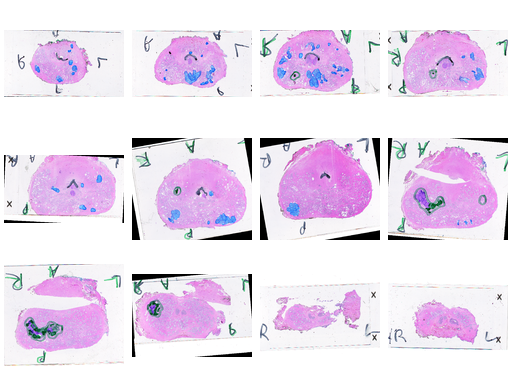

In [103]:
for i in ARFIatrophy:
    montage = '%s/Patient%s/Histology/Images/montage.png' % (invivo_path, i)
    print montage
    display(Image(filename=montage))

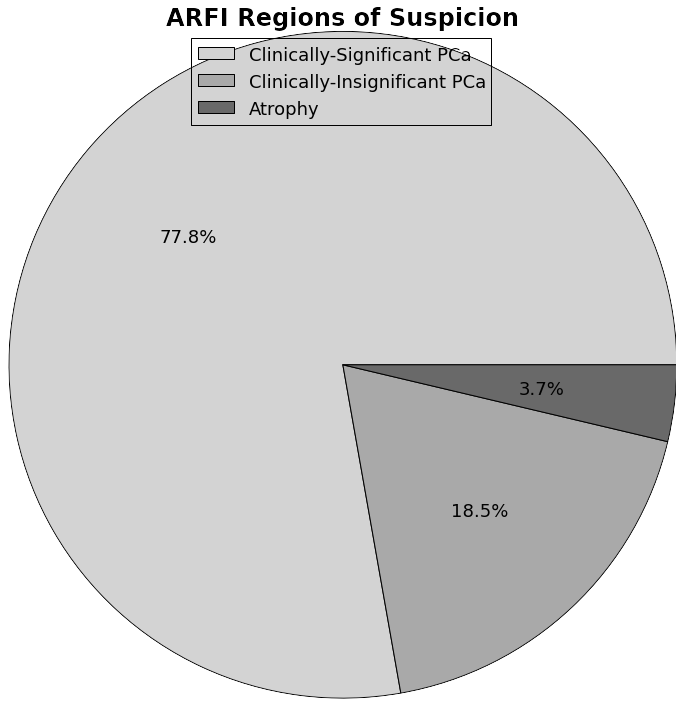

In [110]:
# lets make another pie chart for the ARFI ROSs
labels = ['Clinically-Significant PCa', 'Clinically-Insignificant PCa', 'Atrophy']
colors = ['lightgray', 'darkgray', 'dimgray']

plt.figure(figsize=(12,12))
slices = [ARFIclinsig.c, len(ARFI_ClinInsigPCA), len(ARFIatrophy)]
patches, texts, autotexts = plt.pie(slices, colors=colors, autopct='%1.1f%%')
plt.axis('equal')
plt.title('ARFI Regions of Suspicion', fontsize=24, fontweight='bold')
for i in range(0,len(texts)):
    texts[i].set_fontsize(18)
for i in range(0,len(autotexts)):
    autotexts[i].set_fontsize(18)
#patches[2].set_hatch('x')
#patches[3].set_hatch('x')
plt.legend(patches, labels, fontsize=18, loc='upper center')
#plt.text(-0.5, 0.4, '79% of all index lesions detected', fontsize=18, color='black')
#plt.text(-0.5, 0.3, '81% of posterior index lesions detected', fontsize=18, color='black')
#plt.text(-0.5, 0.2, '50% of anterior index lesions detected', fontsize=18, color='black')
savefig('ARFI_ROS.eps', dpi=1200)

##Clinically-Significant Histology Lesions

In [105]:
ClinSigDetected = []

for p in ValidPatientNums:
    P = LesionAnalysis(p, invivo_path)
    if P.clin_sig_sensitivity:
        ClinSigDetected.append(P.clin_sig_sensitivity)
       
histtotal = len([j for i in ClinSigDetected for j in i])      
histclinsig = countTotalPercent(len([j for i in ClinSigDetected for j in i if j[0]]), histtotal)                  
histposterior = countTotalPercent(len([j for i in ClinSigDetected for j in i if j[1] == 'posterior']), histtotal)  
histanterior = countTotalPercent(len([j for i in ClinSigDetected for j in i if j[1] == 'anterior']), histtotal)
        
print "%i/%i (%.f%%) of clinically-significant histology lesions were detected" % (histclinsig.c, histclinsig.t, histclinsig.p)
write_analysis_result('histClinSigDetect', histclinsig.p)
print "\tLocations: %i/%i (%.f%%) posterior, %i/%i (%.f%%) anterior" % \
    (histposterior.c, histposterior.t, histposterior.p,histanterior.c, histanterior.t, histanterior.p)
write_analysis_result('histClinSigDetectPosterior', histposterior.p)
write_analysis_result('histClinSigDetectAnterior', histanterior.p)

23/34 (68%) of clinically-significant histology lesions were detected
	Locations: 29/34 (85%) posterior, 5/34 (15%) anterior


In [106]:
analysis_results.close()

In [107]:
%%bash
cat analysis_results.tex

% DO NOT MANUALLY EDIT THIS FILE!
% GENERATED BY arfi_histology_lesion_analysis.ipynb
\newcommand{\arfiIndexSensitivity}{78.6}
\newcommand{\arfiPosteriorIndexSensitivity}{80.8}
\newcommand{\arfiAnteriorIndexSensitivity}{50.0}
\newcommand{\arfiClinSig}{77.8}
\newcommand{\arfiClinSigPosterior}{100.0}
\newcommand{\arfiClinSigAnterior}{0.0}
\newcommand{\arfiClinInsigPosterior}{100.0}
\newcommand{\arfiClinInsigAnterior}{0.0}
\newcommand{\histClinSigDetect}{67.6}
\newcommand{\histClinSigDetectPosterior}{85.3}
\newcommand{\histClinSigDetectAnterior}{14.7}
